In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


In [4]:
DATA_FOLDER = '/kaggle/input/stock-time-series-20050101-to-20171231'
# 排除不需要的 CSV 文件
o_exclude = {
    'all_stocks_2006-01-01_to_2018-01-01.csv',
    'all_stocks_2017-01-01_to_2018-01-01.csv'
}
csv_files = [f for f in glob(os.path.join(DATA_FOLDER, '*.csv'))
             if Path(f).name not in o_exclude]
print(f"Found {len(csv_files)} CSV files after exclusion.")

df_sample = pd.read_csv(csv_files[0], parse_dates=['Date']).head()
display(df_sample)

Found 31 CSV files after exclusion.


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,57.87,58.11,57.05,57.80,3697500,CAT
1,2006-01-04,57.95,59.43,57.55,59.27,4577200,CAT
2,2006-01-05,59.02,59.86,59.00,59.27,4590700,CAT
3,2006-01-06,59.47,60.76,59.38,60.45,5692300,CAT
4,2006-01-09,60.45,61.68,60.45,61.55,4409300,CAT


In [5]:
def load_and_preprocess(files):
    """读取所有股票并填充缺失值"""
    df = pd.concat(
        (pd.read_csv(f, parse_dates=['Date']) for f in files),
        ignore_index=True
    )
    df = df.sort_values(['Name', 'Date']).reset_index(drop=True)
    for col in ['Open','High','Low','Close','Volume']:
        df[col] = df[col].fillna((df[col].ffill()+df[col].bfill())/2)
    return df

stock_data = load_and_preprocess(csv_files)
print("Merged shape:", stock_data.shape)
display(stock_data.groupby('Name').size().head())

Merged shape: (93612, 7)


Name
AABA    3019
AAPL    3019
AMZN    3019
AXP     3020
BA      3020
dtype: int64

In [6]:
stock_data['Return'] = stock_data.groupby('Name')['Close'].pct_change().shift(-1)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
train = stock_data[stock_data['Date'] < '2015-01-01']
test  = stock_data[stock_data['Date'] >= '2015-01-01']
print("Train period:", train['Date'].min(), train['Date'].max())
print("Test period:", test['Date'].min(), test['Date'].max())

Train period: 2006-01-03 00:00:00 2014-12-31 00:00:00
Test period: 2015-01-02 00:00:00 2017-12-29 00:00:00


In [7]:
class StockRNNDataset(Dataset):
    def __init__(self, df, time_step=60, features=None):
        self.time_step = time_step
        self.features = features or ['Open','High','Low','Close','Volume']
        self.data = []
        for name, grp in df.groupby('Name'):
            grp = grp.sort_values('Date').reset_index(drop=True)
            X = grp[self.features].values
            y = grp['Return'].values
            if len(grp) < time_step+1: continue
            scaler = StandardScaler().fit(X)
            Xs = scaler.transform(X)
            for i in range(len(grp)-time_step):
                seq = Xs[i:i+time_step]
                label = 1 if y[i+time_step-1]>0 else 0
                self.data.append((seq, label))
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): seq, lbl = self.data[idx]; return torch.FloatTensor(seq), torch.FloatTensor([lbl])

train_ds = StockRNNDataset(train)
test_ds  = StockRNNDataset(test)
print("Train samples:", len(train_ds), "Test samples:", len(test_ds))

Train samples: 68347 Test samples: 21545


In [8]:
class RNNModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=30, num_layers=3, dropout=0.3):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
        self.fc  = nn.Linear(hidden_size,1)
    def forward(self, x):
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size, device=x.device)
        out, _ = self.rnn(x, h0)
        return self.fc(out[:, -1, :])

model = RNNModel().to(device)
print(model)


RNNModel(
  (rnn): RNN(5, 30, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)


In [9]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
opt = optim.Adam(model.parameters(), lr=1e-3)
crit = nn.BCEWithLogitsLoss()
for epoch in range(5):
    total_loss = 0
    model.train()
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        logits = model(Xb)
        loss = crit(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.6936
Epoch 2, Loss: 0.6929
Epoch 3, Loss: 0.6930
Epoch 4, Loss: 0.6929
Epoch 5, Loss: 0.6930


In [10]:
def gen_scores(df):
    rec=[]; model.eval()
    with torch.no_grad():
        for name, grp in df.groupby('Name'):
            grp=grp.sort_values('Date').reset_index(drop=True)
            X=grp[['Open','High','Low','Close','Volume']].values
            if len(X)<60: continue
            sc=StandardScaler().fit(X); Xs=sc.transform(X)
            for i in range(60,len(grp)):
                xb=torch.FloatTensor(Xs[i-60:i]).unsqueeze(0).to(device)
                s=torch.sigmoid(model(xb)).item()
                rec.append((name, grp.loc[i,'Date'], s, grp.loc[i,'Return']))
    return pd.DataFrame(rec, columns=['Name','Date','score','Return'])

df_train=gen_scores(train); df_test=gen_scores(test)
print(df_train.head())

   Name       Date     score    Return
0  AABA 2006-03-30  0.512746 -0.004935
1  AABA 2006-03-31  0.515183 -0.011469
2  AABA 2006-04-03  0.517014  0.006585
3  AABA 2006-04-04  0.517738  0.000312
4  AABA 2006-04-05  0.516046  0.021177


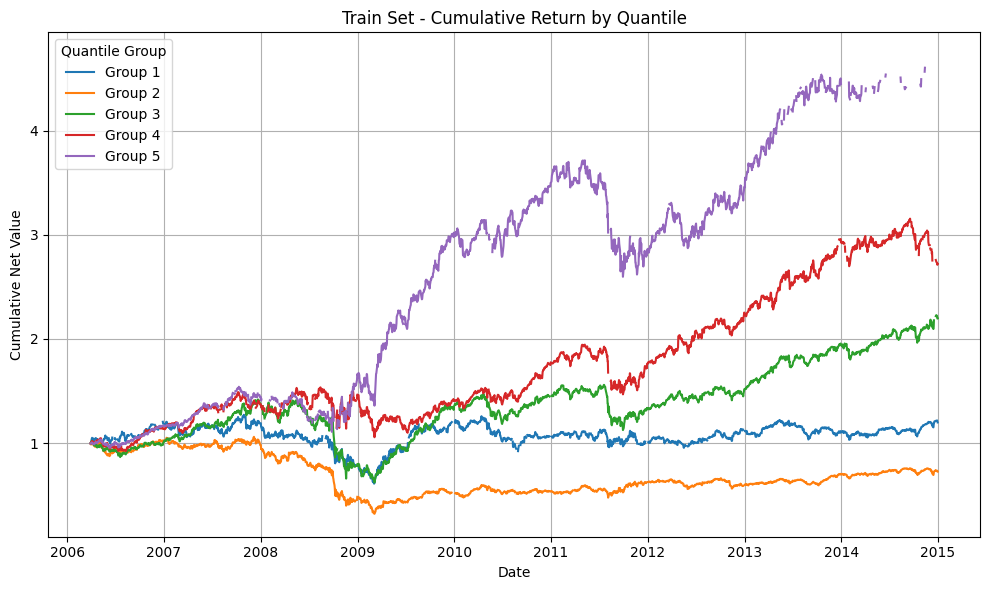

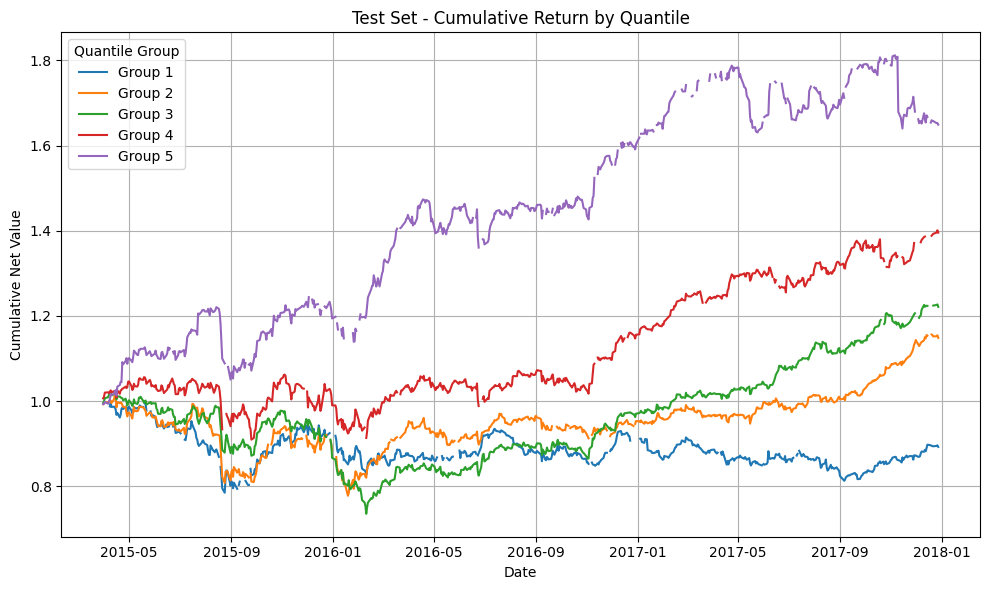

In [13]:
import matplotlib.pyplot as plt

for df, title in [(df_train, 'Train Set'), (df_test, 'Test Set')]:
    df = df.copy()
    df['group'] = pd.qcut(df['score'], 5, labels=False)
    daily = df.groupby(['Date', 'group'])['Return'].mean().unstack().sort_index()
    cum = (1 + daily).cumprod()

    plt.figure(figsize=(10, 6))
    for g in cum.columns:
        plt.plot(cum.index, cum[g], label=f'Group {g+1}')
    plt.title(f'{title} - Cumulative Return by Quantile')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Net Value')
    plt.legend(title='Quantile Group')
    plt.grid(True)
    plt.tight_layout()
    plt.show()